## Task II: Classical Graph Neural Network (GNN) 
For Task II, you will use ParticleNet’s data for Quark/Gluon jet classification available [here](https://zenodo.org/records/3164691) with its corresponding description. 
- Choose 2 Graph-based architectures of your choice to classify jets as being quarks or gluons. Provide a description on what considerations you have taken to project this point-cloud dataset to a set of interconnected nodes and edges. 
- Discuss the resulting performance of the 2 chosen architectures. 


We will write and train Graph Neural Networks with [Pytorch-Geometric Library](https://pytorch-geometric.readthedocs.io/en_latest_index.html). 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torch_geometric as pyg
import torch_geometric.nn as pyg_nn
import torch_geometric.data as pyg_data
import torch_geometric.loader as pyg_loader
import torch_geometric.transforms as T

import networkx as nx
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob, os

### 1. Loading and Pre-processing Data 

We use `InMemoryDataset` class to load and preprocess particle jet data according to methods discussed in the paper Energy Flow Networks: Deep Sets for Particle Jets [1]. 

- **Normalization and Centering**: For each particle, its transverse momentum ($p_{T}$) is normalized by the total $p_{T}$ while rapidity ($y$) and azimuthal angle ($\phi$)  are centered around the weighted mean rapidity and azimuthal angle, respectively:

$$
p_{T,i} \to \frac{p_{T,i}}{\sum_j p_{T,j}}
$$

$$
y_i \to y_i - \left( \sum_j \frac{p_{T,j}}{\sum_k p_{T,k}} y_j \right),\quad \phi_i \to \phi_i - \left( \sum_j \frac{p_{T,j}}{\sum_k p_{T,k}} \phi_j \right)
$$

- **PID Processing**: We will try PFN scheme, which excludes PID labels, and PFN-ID scheme, which encodes PID labels as float values starting at 0 and increases by 0.1 for each distinct type.


In [2]:
class QG_Jets(pyg_data.InMemoryDataset):
    def __init__(self, root, version='pid_as_feature', 
                 transform=None, pre_transform=None, pre_filter=None, force_reload=True):
        self.version = version 
        super().__init__(root, transform, pre_transform)
        self.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        files = glob.glob(self.root + '/raw/*.npz') 
        return [file.split('/')[-1] for file in files]

    @property
    def processed_file_names(self):
        if self.version == 'without_pid':
            return ['data_without_pid.pt']
        elif self.version == 'with_pid':
            return ['data_with_pid.pt']
        else:
            raise ValueError("Invalid version specified. Choose 'without_pid' or 'with_pid'.")

    def download(self) -> None:
        pass  # Assuming data is already downloaded

    def process(self):
        
        data_list = []
        print(self.raw_paths)
        for raw_path in self.raw_paths:
            # Read data from `raw_path`.
            data = np.load(raw_path)

            # Access the arrays stored in the NPZ file
            pcs = data['X']
            ys = data['y']  
            
            # PDGid to float dictionary
            PID2FLOAT_MAP = {22: 0,
                 211: .1, -211: .2,
                 321: .3, -321: .4,
                 130: .5,
                 2112: .6, -2112: .7,
                 2212: .8, -2212: .9,
                 11: 1.0, -11: 1.1,
                 13: 1.2, -13: 1.3,
                 0: 1.5,  # Representing undefined PID
                 }
            
            pids = np.unique(pcs[:, :, 3]).flatten()
            print("PIDS:", pids)
            for index, pc in enumerate(pcs):
                # Remove zero-padding
                pc = pc[~np.all(pc == 0, axis=1)]
                
                pt_total = np.sum(pc[:, 0])  # Total scalar sum of p_T
                
                # Center y and phi
                weighted_y = np.sum(pc[:, 0] * pc[:, 1]) / pt_total
                weighted_phi = np.sum(pc[:, 0] * pc[:, 2]) / pt_total
                pc[:, 1] = pc[:, 1] - weighted_y
                pc[:, 2] = pc[:, 2] - weighted_phi
                
                # Normalize p_T
                pc[:, 0] = pc[:, 0] / pt_total
            
                for pid in pids:
                    np.place(pc[:, 3], pc[:, 3] == pid, PID2FLOAT_MAP[pid])
            
                if self.version == 'without_pid':
                    data = pyg_data.Data(x = torch.tensor(pc[:, :3], 
                                               dtype=torch.float), 
                                         pos = torch.tensor(pc[:, :3], 
                                               dtype=torch.float),
                                         y=int(ys[index]))
                elif self.version == 'with_pid':
                    data = pyg_data.Data(x = torch.tensor(pc, 
                                               dtype=torch.float), 
                                         pos = torch.tensor(pc[:, :3], 
                                               dtype=torch.float),
                                         y=int(ys[index]))
                data_list.append(data)

        self.save(data_list, self.processed_paths[0])

        return data_list

### 2. PyTorch Lightning for GNN Training

We utilize a PyTorch Lightning Module to streamline the training, validation, and testing of GNN, such as logging metrics of loss, accuracy, and AUC (Area Under the Curve) across different phases.

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Device:", device)
batch_size = 256

class ModelPL(pl.LightningModule):
    def __init__(self, model, learning_rate=0.01):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.criterion = torch.nn.CrossEntropyLoss()
        
        from torchmetrics import AUROC, Accuracy 
        self.train_auc = AUROC(task='binary')
        self.val_auc = AUROC(task='binary')
        self.test_auc = AUROC(task='binary')
        
        self.train_acc = Accuracy(task='binary')
        self.val_acc = Accuracy(task='binary')
        self.test_acc = Accuracy(task='binary')

    def forward(self, data):
        return self.model(data)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
        lr_scheduler = {
            'scheduler': optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                        mode='min', factor=0.25, patience=1),
            'monitor': 'val_loss', 
            'interval': 'epoch',
            'frequency': 1
        }
        return [optimizer], [lr_scheduler]

    def training_step(self, data, batch_idx):
        lr = self.optimizers().param_groups[0]['lr']
        self.log('learning_rate', lr, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)
        
        logits = self(data)
        loss = self.criterion(logits.squeeze(), data.y)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)
        
        self.train_auc(F.softmax(logits.squeeze(), dim=1)[:, 1], data.y)
        self.log("train_auc", self.train_auc, on_step=False, on_epoch=True, prog_bar=False, batch_size=batch_size)
        
        self.train_acc(logits.argmax(dim=-1), data.y)
        self.log('train_acc', self.train_acc, on_step=False, on_epoch=True, prog_bar=False, batch_size=batch_size)
        
        return loss

    def validation_step(self, data, batch_idx):
        logits = self(data)
        loss = self.criterion(logits.squeeze(), data.y)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)
        
        self.val_auc(F.softmax(logits.squeeze(), dim=1)[:, 1], data.y)
        self.log("val_auc", self.val_auc, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)
        
        self.val_acc(logits.argmax(dim=-1), data.y)
        self.log('val_acc', self.val_acc, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)

    def test_step(self, data, batch_idx):
        logits = self(data)
        
        self.test_auc(F.softmax(logits.squeeze(), dim=1)[:, 1], data.y)
        self.log("test_auc", self.test_auc, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)
        
        self.test_acc(logits.argmax(dim=-1), data.y)
        self.log('test_acc', self.test_acc, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)


Device: cuda


### 3. GNN Models

PyTorch Geometric provides a convenient set of tools and pre-defined layers for constructing Graph Neural Networks (GNNs). Utilizing those, we explore the usages of several GNN architectures for the task of classifying Quark vs. Gluon Jets. 


#### 3.1 PointNet++

PointNet++ is an advanced version of PointNet that proposes a Graph Neural Network architecture for point cloud classification, designed to capture the hierarchical structure of point clouds by progressively aggregating local features i.e

$$
\mathbf{h}^{(\ell + 1)}_i = \max_{j \in \mathcal{N}(i)} \textrm{MLP} \left( \mathbf{h}_j^{(\ell)}, \mathbf{p}_j - \mathbf{p}_i \right)
$$

such that $\mathbf{h}_i^{(\ell)} $ is the hidden feature at point $i$ in layer $l$ and $p_i$ is the position at point $i$. [2] 

In [4]:
class PointNetLayer(pyg_nn.MessagePassing):
    def __init__(self, in_channels, out_channels, pos_dim=3):
        super().__init__(aggr='max')

        self.mlp = nn.Sequential(
            nn.Linear(in_channels + pos_dim, out_channels),
            nn.ReLU(),
            nn.Linear(out_channels, out_channels),
        )

    def forward(self, h, pos, edge_index):
        # Start propagating messages.
        return self.propagate(edge_index, h=h, pos=pos)

    def message(self, h_j, pos_j, pos_i):
        # h_j: The features of neighbors as shape [num_edges, in_channels]
        # pos_j: The position of neighbors as shape [num_edges, pos_dim]
        # pos_i: The central node position as shape [num_edges, pos_dim]

        edge_feat = torch.cat([h_j, pos_j - pos_i], dim=-1)
        return self.mlp(edge_feat)
    
class PointNet(nn.Module):
    def __init__(self, input_features=4, pos_dim=3, hidden_dim=16, output_dim=2, dropout_rate=0.1):
        super().__init__()

        self.conv1 = PointNetLayer(input_features, hidden_dim, pos_dim=pos_dim)
        self.conv2 = PointNetLayer(hidden_dim, hidden_dim, pos_dim=pos_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = pyg_nn.MLP([hidden_dim, hidden_dim, output_dim], bias=[False, True])

    def forward(self, data):
        x, pos, edge_index, batch = data.x, data.pos, data.edge_index, data.batch
        
        # First PointNetLayer layer
        x = self.conv1(h=x, pos=pos, edge_index=edge_index)
        x = x.relu()
        # x = self.dropout(x)
        
        # Second PointNetLayer layer
        x = self.conv2(h=x, pos=pos, edge_index=edge_index)
        x = x.relu()
        # x = self.dropout(h)
        
        # Global Pooling:
        x = pyg_nn.global_max_pool(x, batch)  # [num_examples, hidden_channels]
        
        # Classifier:
        return self.classifier(x)

#### 3.2 Dynamic Graph CNN

The Dynamic Graph CNN extends traditional GNNs by dynamically updating the graph's edge connections at each layer of the network. It leverages EdgeConv operations, which compute features on edges dynamically created based on the k-nearest neighbors in the feature space. [3]

Note that if `h` (the feature vector of the nodes) is the same as `pos` (the positional vector of the nodes), the `PointNetLayer` implemented before would behave similarly to a static version of `pyg_nn.DynamicEdgeConv` i.e `pyg_nn.EdgeConv`.

In [5]:
class DynGCNN(torch.nn.Module):
    def __init__(self, input_features=4, hidden_dim=16, output_dim=2, dropout_rate=0.1, ks=[4,8], aggr='max'):
        super(DynGCNN, self).__init__()
        
        # MLPs for DynamicEdgeConv
        mlp1 = nn.Sequential(nn.Linear(2 * input_features, hidden_dim), 
                             nn.ReLU(), 
                             nn.Linear(hidden_dim, hidden_dim))
        
        mlp2 = nn.Sequential(nn.Linear(2 * hidden_dim, hidden_dim), 
                             nn.ReLU(), 
                             nn.Linear(hidden_dim, hidden_dim))
        
        # DynamicEdgeConv layers
        self.conv1 = pyg_nn.DynamicEdgeConv(mlp1, k=ks[0], aggr=aggr)
        self.conv2 = pyg_nn.DynamicEdgeConv(mlp2, k=ks[1], aggr=aggr)
        
        # Classifier
        self.classifier = nn.Linear(2 * hidden_dim, output_dim)
        
        # Dropout
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # First DynamicEdgeConv layer
        x1 = self.conv1(x, edge_index)
        x1 = F.relu(x1)
        x1 = self.dropout(x1)
        
        # Second DynamicEdgeConv layer
        x2 = self.conv2(x1, edge_index)
        x2 = F.relu(x2)
        
        # Aggregating outputs from both EdgeConv layers along the feature dimension
        x_aggregated = torch.cat([x1, x2], dim=1) 
        
        # Global Pooling
        x_pooled = pyg_nn.global_max_pool(x_aggregated, batch) 
        
        # Classifier 
        x_out = self.classifier(x_pooled)
        
        return x_out

#### 3.3 Graph Attention Net

The Graph Attention Net introduces an attention-based mechanism to weigh the influence of neighboring nodes during feature aggregation. By learning different attention weights for each edge, GAT allows for adaptive feature learning, focusing more on relevant neighbors and less on irrelevant ones. [4]

In [5]:
class GATNet(nn.Module):
    def __init__(self, input_features=4, hidden_dim=16, output_dim=2, heads=2, dropout_rate=0.1):
        super(GATNet, self).__init__()

        # GATConv layers
        self.conv1 = pyg_nn.GATConv(input_features, hidden_dim, heads=heads, concat=True, dropout=dropout_rate)
        self.conv2 = pyg_nn.GATConv(hidden_dim * heads, hidden_dim, heads=heads, concat=False)
        
        # Classifier
        self.classifier = nn.Linear(hidden_dim, output_dim)
        
        # Dropout
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        # First GATConv layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # x = self.dropout(x)

        # Second GATConv layer
        x = self.conv2(x, edge_index)
        x = F.relu(x) 

        # Global Pooling
        x = pyg_nn.global_max_pool(x, batch)

        # Classifier
        x = self.classifier(x)

        return x

### Training

Our experimentation involves two versions of the dataset: one incorporating PID information and the other omitting it. By adjusting the k parameter for the k-Nearest Neighbors (KNN) algorithm, we can also induce different transformations for each dataset. Furthermore, despite each model streamlined to include only two graph convolutional layers, there are varying settings of parameters can significantly influence the training outcomes.

However, we are most curious about the impact of PID information on model performance as well as the significance of local features, which is assessed with comparisons between complete (fully connected) and sparse graph structures. We will also not aim to fine-tune the parameters, but only strive for fair comparison and quick iteration by initially aligning the models' configurations to about 1k trainable params. It is worth noting that the number of params in [1], specifically referenced to "three dense layers with 100 nodes", is in the order of 10k.  

#### Loading Dataset

In [8]:
dataset_1 = QG_Jets('./data/QG_Jets', version='without_pid')
print(f"Length: {len(dataset_1)}, Info: {dataset_1[0]}, Sample...: \n{dataset_1[0].x[:5]}")

dataset_2 = QG_Jets('./data/QG_Jets', version='with_pid')
print(f"Length: {len(dataset_2)}, Info: {dataset_2[0]}, Sample...: \n{dataset_2[0].x[:5]}")

Length: 100000, Info: Data(x=[18, 3], y=[1], pos=[18, 3]), Sample...: 
tensor([[ 5.3666e-04,  3.8694e-01, -8.9608e-03],
        [ 3.1963e-04, -2.2557e-01, -2.0012e-01],
        [ 2.2936e-03, -3.2403e-02, -2.4649e-01],
        [ 8.2497e-03,  2.0372e-01,  1.5876e-02],
        [ 3.3865e-03, -1.8214e-01,  4.6523e-02]])
Length: 100000, Info: Data(x=[18, 4], y=[1], pos=[18, 3]), Sample...: 
tensor([[ 5.3666e-04,  3.8694e-01, -8.9608e-03,  0.0000e+00],
        [ 3.1963e-04, -2.2557e-01, -2.0012e-01,  0.0000e+00],
        [ 2.2936e-03, -3.2403e-02, -2.4649e-01,  2.0000e-01],
        [ 8.2497e-03,  2.0372e-01,  1.5876e-02,  4.0000e-01],
        [ 3.3865e-03, -1.8214e-01,  4.6523e-02,  2.0000e-01]])


In [9]:
total_size = 100000

train_size = int(0.6 * total_size)
val_size = int(0.2 * total_size)
test_size = int(0.2 * total_size)

#### Dynamic Graph CNN

The Dynamic Graph CNN (DGCNN) only requires nodes data for its operations. We conduct training twice: one excluding PID and another including PID. 

In [10]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset_1, [train_size, val_size, test_size])

train_loader = pyg_loader.DataLoader(train_dataset, batch_size=batch_size, num_workers = 12)
val_loader = pyg_loader.DataLoader(val_dataset, batch_size=batch_size, num_workers = 12)
test_loader = pyg_loader.DataLoader(test_dataset, batch_size=batch_size, num_workers = 12)

dyngcnn = DynGCNN(input_features=3) # 3 for without_pid

DynGCNN_pl = ModelPL(model=dyngcnn, learning_rate=0.01)

logger = pl.loggers.CSVLogger(save_dir='logs', name='dyngcnn_without_pid', version=0)

summary_callback = pl.callbacks.ModelSummary(max_depth=8)
callbacks = [summary_callback]

trainer_dynGCNN = pl.Trainer(max_epochs=15, 
                            accelerator='gpu' if str(device).startswith('cuda') else 'cpu',
                            callbacks=callbacks,
                            logger=logger,)

train_result = trainer_dynGCNN.fit(DynGCNN_pl, train_dataloaders=train_loader, val_dataloaders=val_loader)
test_result = trainer_dynGCNN.test(dataloaders=test_loader)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                    | Type             | Params
--------------------------------------------------------------
0  | model                   | DynGCNN          | 1.2 K 
1  | model.conv1             | DynamicEdgeConv  | 384   
2  | model.conv1.ag

Sanity Checking: 0it [00:00, ?it/s]

Epoch 14: 100%|██████████| 314/314 [00:33<00:00,  9.43it/s, loss=0.491, v_num=0, val_loss=0.499, val_auc=0.840, val_acc=0.762, learning_rate=0.000625, train_loss=0.500]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 314/314 [00:33<00:00,  9.42it/s, loss=0.491, v_num=0, val_loss=0.499, val_auc=0.840, val_acc=0.762, learning_rate=0.000625, train_loss=0.500]


You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at logs/dyngcnn_without_pid/version_0/checkpoints/epoch=14-step=3525-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at logs/dyngcnn_without_pid/version_0/checkpoints/epoch=14-step=3525-v1.ckpt


Testing DataLoader 0: 100%|██████████| 79/79 [00:06<00:00, 11.34it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7573000192642212
        test_auc            0.8333536386489868
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [10]:

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset_2, [train_size, val_size, test_size])

train_loader = pyg_loader.DataLoader(train_dataset, batch_size=batch_size, num_workers = 12)
val_loader = pyg_loader.DataLoader(val_dataset, batch_size=batch_size, num_workers = 12)
test_loader = pyg_loader.DataLoader(test_dataset, batch_size=batch_size, num_workers = 12)

DynGCNN = DynGCNN(input_features=4) # 4 for with_pid

DynGCNN_pl = ModelPL(model=DynGCNN, learning_rate=0.01)

logger = pl.loggers.CSVLogger(save_dir='logs', name='dyngcnn_with_pid', version=0)

summary_callback = pl.callbacks.ModelSummary(max_depth=8)
callbacks = [summary_callback]

trainer_dynGCNN = pl.Trainer(max_epochs=15, 
                            accelerator='gpu' if str(device).startswith('cuda') else 'cpu',
                            callbacks=callbacks,
                            logger=logger,)

train_result = trainer_dynGCNN.fit(DynGCNN_pl, train_dataloaders=train_loader, val_dataloaders=val_loader)
test_result = trainer_dynGCNN.test(dataloaders=test_loader)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                    | Type             | Params
--------------------------------------------------------------
0  | model                   | DynGCNN          | 1.3 K 
1  | model.conv1             | DynamicEdgeConv  | 416   
2  | model.conv1.ag

Epoch 14: 100%|██████████| 314/314 [00:31<00:00,  9.82it/s, loss=0.48, v_num=0, val_loss=0.490, val_auc=0.845, val_acc=0.769, learning_rate=0.0025, train_loss=0.480] 

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 314/314 [00:32<00:00,  9.81it/s, loss=0.48, v_num=0, val_loss=0.490, val_auc=0.845, val_acc=0.769, learning_rate=0.0025, train_loss=0.480]


You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at logs/dyngcnn_with_pid/version_0/checkpoints/epoch=14-step=3525.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at logs/dyngcnn_with_pid/version_0/checkpoints/epoch=14-step=3525.ckpt


Testing DataLoader 0: 100%|██████████| 79/79 [00:07<00:00, 11.28it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7784000039100647
        test_auc            0.8526793718338013
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


#### PointNet++

PointNet++, along with most graph convolutional models, requires edge information for processing. We employ `T.KNNGraph` for grouping nodes based on their `pos` attribute, which is irrespective of PID inclusion, and create edges. By setting a sufficiently high `k`, we can simulate complete graphs and compare with sparse graphs input with a lower `k` setting.

Data(x=[27, 3], y=[1], pos=[27, 3], edge_index=[2, 702])
Node degree: 26.00
Has isolated nodes: False
Has self-loops: False
Is undirected: True


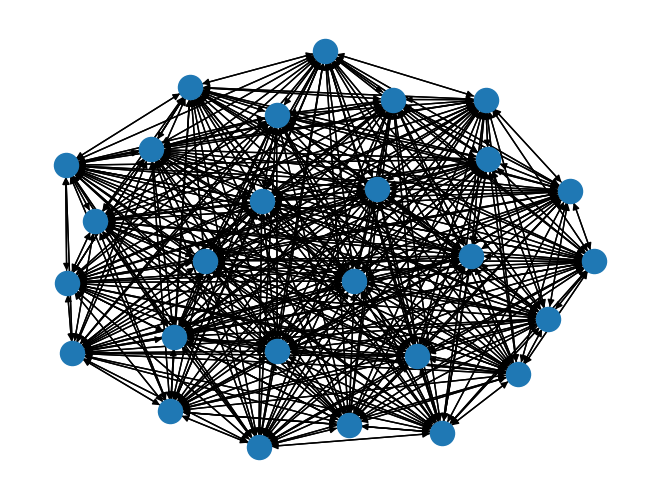

In [36]:
dataset_1.transform = T.Compose([T.KNNGraph(k=50)]) # Set k high for fully connected
sample = dataset_1[10]
print(sample)

print(f'Node degree: {sample.num_edges / sample.num_nodes:.2f}')
print(f'Has isolated nodes: {sample.has_isolated_nodes()}')
print(f'Has self-loops: {sample.has_self_loops()}')
print(f'Is undirected: {sample.is_undirected()}')
nx.draw(pyg.utils.to_networkx(dataset_1[10]))

In [37]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset_1, [train_size, val_size, test_size])

train_loader = pyg_loader.DataLoader(train_dataset, batch_size=batch_size, num_workers = 12)
val_loader = pyg_loader.DataLoader(val_dataset, batch_size=batch_size, num_workers = 12)
test_loader = pyg_loader.DataLoader(test_dataset, batch_size=batch_size, num_workers = 12)

pointnet = PointNet(input_features=3, pos_dim=3) 

pointnet_pl = ModelPL(model=pointnet, learning_rate=0.01)

logger = pl.loggers.CSVLogger(save_dir='logs', name='pointnets_without_pid_c', version=0)

summary_callback = pl.callbacks.ModelSummary(max_depth=8)
callbacks = [summary_callback]

trainer_pointnet = pl.Trainer(max_epochs=15, 
                              accelerator='gpu' if str(device).startswith('cuda') else 'cpu',
                              callbacks=callbacks,
                              logger=logger,)

train_result = trainer_pointnet.fit(pointnet_pl, train_dataloaders=train_loader, val_dataloaders=val_loader)
test_result = trainer_pointnet.test(dataloaders=test_loader)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/ubuntu20_1/Miniconda3/envs/py39_qml/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory logs/pointnets_without_pid_fc/version_0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and i

Epoch 1:  33%|███▎      | 104/314 [00:08<00:16, 12.99it/s, loss=0.523, v_num=0, val_loss=0.526, val_auc=0.819, val_acc=0.742, learning_rate=0.010, train_loss=0.519]

Epoch 14: 100%|██████████| 314/314 [00:24<00:00, 12.96it/s, loss=0.47, v_num=0, val_loss=0.478, val_auc=0.854, val_acc=0.778, learning_rate=0.000625, train_loss=0.468] 

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 314/314 [00:24<00:00, 12.93it/s, loss=0.47, v_num=0, val_loss=0.478, val_auc=0.854, val_acc=0.778, learning_rate=0.000625, train_loss=0.468]


You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at logs/pointnets_without_pid_fc/version_0/checkpoints/epoch=14-step=3525-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at logs/pointnets_without_pid_fc/version_0/checkpoints/epoch=14-step=3525-v1.ckpt


Testing DataLoader 0: 100%|██████████| 79/79 [00:04<00:00, 17.10it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7772499918937683
        test_auc            0.8575296998023987
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Data(x=[27, 3], y=[1], pos=[27, 3], edge_index=[2, 216])
Node degree: 8.00
Has isolated nodes: False
Has self-loops: False
Is undirected: False


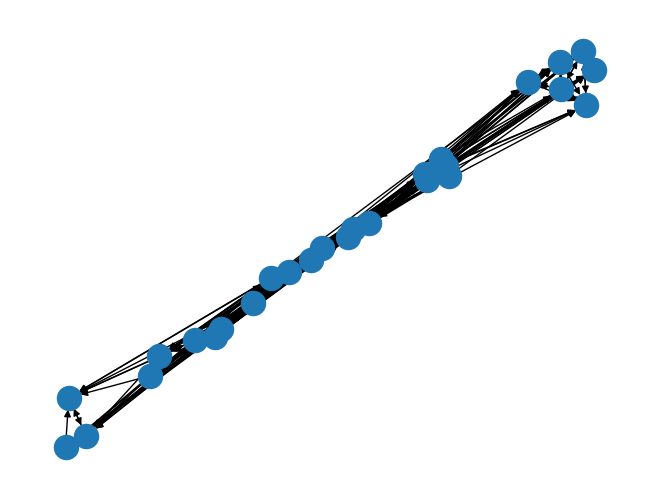

In [34]:
dataset_1.transform = T.Compose([T.KNNGraph(k=8)]) 
sample = dataset_1[10]
print(sample)

print(f'Node degree: {sample.num_edges / sample.num_nodes:.2f}')
print(f'Has isolated nodes: {sample.has_isolated_nodes()}')
print(f'Has self-loops: {sample.has_self_loops()}')
print(f'Is undirected: {sample.is_undirected()}')
nx.draw(pyg.utils.to_networkx(dataset_1[10]))

In [35]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset_1, [train_size, val_size, test_size])

train_loader = pyg_loader.DataLoader(train_dataset, batch_size=batch_size, num_workers = 12)
val_loader = pyg_loader.DataLoader(val_dataset, batch_size=batch_size, num_workers = 12)
test_loader = pyg_loader.DataLoader(test_dataset, batch_size=batch_size, num_workers = 12)

pointnet = PointNet(input_features=3, pos_dim=3) 

pointnet_pl = ModelPL(model=pointnet, learning_rate=0.01)

logger = pl.loggers.CSVLogger(save_dir='logs', name='pointnets_without_pid_s', version=0)

summary_callback = pl.callbacks.ModelSummary(max_depth=8)
callbacks = [summary_callback]

trainer_pointnet = pl.Trainer(max_epochs=15, 
                              accelerator='gpu' if str(device).startswith('cuda') else 'cpu',
                              callbacks=callbacks,
                              logger=logger,)

train_result = trainer_pointnet.fit(pointnet_pl, train_dataloaders=train_loader, val_dataloaders=val_loader)
test_result = trainer_pointnet.test(dataloaders=test_loader)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/ubuntu20_1/Miniconda3/envs/py39_qml/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory logs/pointnets_without_pid_pc/version_0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and i

Epoch 0:  83%|████████▎ | 262/314 [00:29<00:05,  8.89it/s, loss=0.499, v_num=0]

Epoch 14: 100%|██████████| 314/314 [00:18<00:00, 16.87it/s, loss=0.479, v_num=0, val_loss=0.475, val_auc=0.854, val_acc=0.780, learning_rate=0.000625, train_loss=0.469]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 314/314 [00:18<00:00, 16.83it/s, loss=0.479, v_num=0, val_loss=0.475, val_auc=0.854, val_acc=0.780, learning_rate=0.000625, train_loss=0.469]


/home/ubuntu20_1/Miniconda3/envs/py39_qml/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:124: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at logs/pointnets_without_pid_pc/version_0/checkpoints/epoch=14-step=3525-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weight

Testing DataLoader 0: 100%|██████████| 79/79 [00:03<00:00, 22.73it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7763000130653381
        test_auc             0.853226363658905
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


We observe that sparse graphs with k=8 and complete graphs input have similar accuracy and AUC for PointNet model. It's worth noting that alternative configurations of k might result in different performance.

Now, let's try evaluating the model again with pid info included. 

In [38]:
dataset_2.transform = T.Compose([T.KNNGraph(k=50)])

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset_2, [train_size, val_size, test_size])

In [39]:
train_loader = pyg_loader.DataLoader(train_dataset, batch_size=batch_size, num_workers = 12)
val_loader = pyg_loader.DataLoader(val_dataset, batch_size=batch_size, num_workers = 12)
test_loader = pyg_loader.DataLoader(test_dataset, batch_size=batch_size, num_workers = 12)

pointnet = PointNet(input_features=4, pos_dim=3) 

pointnet_pl = ModelPL(model=pointnet, learning_rate=0.01)

logger = pl.loggers.CSVLogger(save_dir='logs', name='pointnets_with_pid_c', version=0)

summary_callback = pl.callbacks.ModelSummary(max_depth=8)
callbacks = [summary_callback]

trainer_pointnet = pl.Trainer(max_epochs=15, 
                              accelerator='gpu' if str(device).startswith('cuda') else 'cpu',
                              callbacks=callbacks,
                              logger=logger,)

train_result = trainer_pointnet.fit(pointnet_pl, train_dataloaders=train_loader, val_dataloaders=val_loader)
test_result = trainer_pointnet.test(dataloaders=test_loader)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                            | Type             | Params
----------------------------------------------------------------------
0  | model                           | PointNet         | 1.3 K 
1  | model.conv1                     | PointNetLayer

Epoch 14: 100%|██████████| 314/314 [00:28<00:00, 11.05it/s, loss=0.451, v_num=0, val_loss=0.455, val_auc=0.867, val_acc=0.795, learning_rate=0.000625, train_loss=0.455]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 314/314 [00:28<00:00, 11.04it/s, loss=0.451, v_num=0, val_loss=0.455, val_auc=0.867, val_acc=0.795, learning_rate=0.000625, train_loss=0.455]


You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at logs/pointnets_with_pid_fc/version_0/checkpoints/epoch=14-step=3525.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at logs/pointnets_with_pid_fc/version_0/checkpoints/epoch=14-step=3525.ckpt


Testing DataLoader 0: 100%|██████████| 79/79 [00:04<00:00, 17.71it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7941499948501587
        test_auc            0.8666018843650818
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [40]:
dataset_2.transform = T.Compose([T.KNNGraph(k=8)])

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset_2, [train_size, val_size, test_size])

In [41]:
train_loader = pyg_loader.DataLoader(train_dataset, batch_size=batch_size, num_workers = 12)
val_loader = pyg_loader.DataLoader(val_dataset, batch_size=batch_size, num_workers = 12)
test_loader = pyg_loader.DataLoader(test_dataset, batch_size=batch_size, num_workers = 12)

pointnet = PointNet(input_features=4, pos_dim=3) 

pointnet_pl = ModelPL(model=pointnet, learning_rate=0.01)

logger = pl.loggers.CSVLogger(save_dir='logs', name='pointnets_with_pid_s', version=0)

summary_callback = pl.callbacks.ModelSummary(max_depth=8)
callbacks = [summary_callback]

trainer_pointnet = pl.Trainer(max_epochs=15, 
                              accelerator='gpu' if str(device).startswith('cuda') else 'cpu',
                              callbacks=callbacks,
                              logger=logger,)

train_result = trainer_pointnet.fit(pointnet_pl, train_dataloaders=train_loader, val_dataloaders=val_loader)
test_result = trainer_pointnet.test(dataloaders=test_loader)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/ubuntu20_1/Miniconda3/envs/py39_qml/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory logs/pointnets_with_pid_pc/version_0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is n

Sanity Checking: 0it [00:00, ?it/s]

Epoch 14: 100%|██████████| 314/314 [00:23<00:00, 13.24it/s, loss=0.462, v_num=0, val_loss=0.467, val_auc=0.860, val_acc=0.787, learning_rate=0.000156, train_loss=0.463]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 314/314 [00:23<00:00, 13.22it/s, loss=0.462, v_num=0, val_loss=0.467, val_auc=0.860, val_acc=0.787, learning_rate=0.000156, train_loss=0.463]


You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at logs/pointnets_with_pid_pc/version_0/checkpoints/epoch=14-step=3525-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at logs/pointnets_with_pid_pc/version_0/checkpoints/epoch=14-step=3525-v1.ckpt


Testing DataLoader 0: 100%|██████████| 79/79 [00:04<00:00, 17.66it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7876999974250793
        test_auc             0.863845705986023
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


#### GAT Net

We will proceed with experiments similar to PointNet:

Data(x=[27, 3], y=[1], pos=[27, 3], edge_index=[2, 702])
Node degree: 26.00
Has isolated nodes: False
Has self-loops: False
Is undirected: True


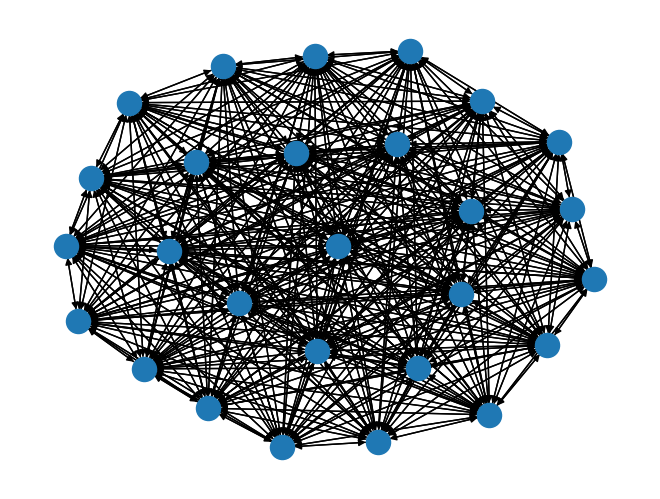

In [29]:
dataset_1.transform = T.Compose([T.KNNGraph(k=50)]) # Set k high for fully connected
sample = dataset_1[10]
print(sample)

print(f'Node degree: {sample.num_edges / sample.num_nodes:.2f}')
print(f'Has isolated nodes: {sample.has_isolated_nodes()}')
print(f'Has self-loops: {sample.has_self_loops()}')
print(f'Is undirected: {sample.is_undirected()}')
nx.draw(pyg.utils.to_networkx(dataset_1[10]))

In [30]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset_1, [train_size, val_size, test_size])

train_loader = pyg_loader.DataLoader(train_dataset, batch_size=batch_size, num_workers = 12)
val_loader = pyg_loader.DataLoader(val_dataset, batch_size=batch_size, num_workers = 12)
test_loader = pyg_loader.DataLoader(test_dataset, batch_size=batch_size, num_workers = 12)

gatnet = GATNet(input_features=3) # 3 for without pid

gatnet_pl = ModelPL(model=gatnet, learning_rate=0.01)

logger = pl.loggers.CSVLogger(save_dir='logs', name='gatnets_without_pid_c', version=0)

summary_callback = pl.callbacks.ModelSummary(max_depth=8)
callbacks = [summary_callback]

trainer_gatnet = pl.Trainer(max_epochs=15, 
                            accelerator='gpu' if str(device).startswith('cuda') else 'cpu',
                            callbacks=callbacks,
                            logger=logger,)

train_result = trainer_gatnet.fit(gatnet_pl, train_dataloaders=train_loader, val_dataloaders=val_loader)
test_result = trainer_gatnet.test(dataloaders=test_loader)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/ubuntu20_1/Miniconda3/envs/py39_qml/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory logs/gatnets_without_pid_fc/version_0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is 

Sanity Checking: 0it [00:00, ?it/s]

Epoch 14: 100%|██████████| 314/314 [00:22<00:00, 13.93it/s, loss=0.467, v_num=0, val_loss=0.477, val_auc=0.853, val_acc=0.781, learning_rate=3.91e-5, train_loss=0.471] 

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 314/314 [00:22<00:00, 13.88it/s, loss=0.467, v_num=0, val_loss=0.477, val_auc=0.853, val_acc=0.781, learning_rate=3.91e-5, train_loss=0.471]


/home/ubuntu20_1/Miniconda3/envs/py39_qml/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:124: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at logs/gatnets_without_pid_fc/version_0/checkpoints/epoch=14-step=3525-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights 

Testing DataLoader 0: 100%|██████████| 79/79 [00:04<00:00, 17.96it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7767000198364258
        test_auc            0.8488408327102661
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Data(x=[27, 3], y=[1], pos=[27, 3], edge_index=[2, 216])
Node degree: 8.00
Has isolated nodes: False
Has self-loops: False


Is undirected: False


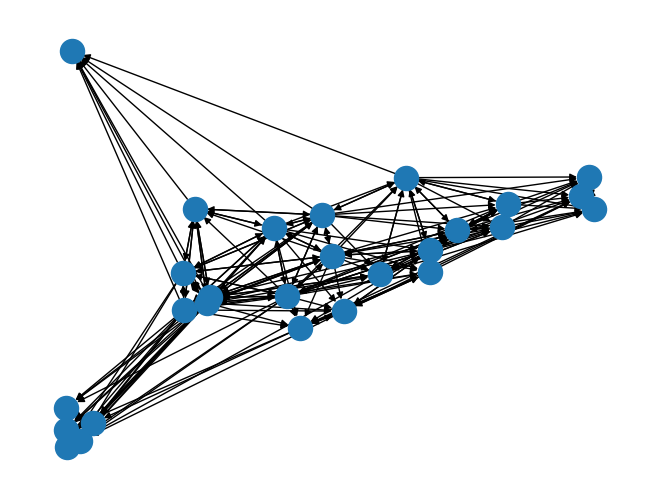

In [31]:
dataset_1.transform = T.Compose([T.KNNGraph(k=8)]) 
sample = dataset_1[10]
print(sample)

print(f'Node degree: {sample.num_edges / sample.num_nodes:.2f}')
print(f'Has isolated nodes: {sample.has_isolated_nodes()}')
print(f'Has self-loops: {sample.has_self_loops()}')
print(f'Is undirected: {sample.is_undirected()}')
nx.draw(pyg.utils.to_networkx(dataset_1[10]))

In [32]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset_1, [train_size, val_size, test_size])

train_loader = pyg_loader.DataLoader(train_dataset, batch_size=batch_size, num_workers = 12)
val_loader = pyg_loader.DataLoader(val_dataset, batch_size=batch_size, num_workers = 12)
test_loader = pyg_loader.DataLoader(test_dataset, batch_size=batch_size, num_workers = 12)

gatnet = GATNet(input_features=3) 

gatnet_pl = ModelPL(model=gatnet, learning_rate=0.01)

logger = pl.loggers.CSVLogger(save_dir='logs', name='gatnets_without_pid_s', version=0)

summary_callback = pl.callbacks.ModelSummary(max_depth=8)
callbacks = [summary_callback]

trainer_gatnet = pl.Trainer(max_epochs=15, 
                            accelerator='gpu' if str(device).startswith('cuda') else 'cpu',
                            callbacks=callbacks,
                            logger=logger,)

train_result = trainer_gatnet.fit(gatnet_pl, train_dataloaders=train_loader, val_dataloaders=val_loader)
test_result = trainer_gatnet.test(dataloaders=test_loader)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/ubuntu20_1/Miniconda3/envs/py39_qml/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory logs/gatnets_without_pid_pc/version_0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is 

Epoch 14: 100%|██████████| 314/314 [00:24<00:00, 12.71it/s, loss=0.457, v_num=0, val_loss=0.466, val_auc=0.861, val_acc=0.787, learning_rate=0.0025, train_loss=0.471]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 314/314 [00:24<00:00, 12.69it/s, loss=0.457, v_num=0, val_loss=0.466, val_auc=0.861, val_acc=0.787, learning_rate=0.0025, train_loss=0.471]


You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at logs/gatnets_without_pid_pc/version_0/checkpoints/epoch=14-step=3525-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at logs/gatnets_without_pid_pc/version_0/checkpoints/epoch=14-step=3525-v1.ckpt


Testing DataLoader 0: 100%|██████████| 79/79 [00:04<00:00, 17.32it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7817999720573425
        test_auc            0.8574429750442505
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In the case of GAT Net, we observe superior performance in the case of sparse graphs input. Let's try the dataset with PID included.

In [12]:
dataset_2.transform = T.Compose([T.KNNGraph(k=8)]) 

In [14]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset_2, [train_size, val_size, test_size])

train_loader = pyg_loader.DataLoader(train_dataset, batch_size=batch_size, num_workers = 12)
val_loader = pyg_loader.DataLoader(val_dataset, batch_size=batch_size, num_workers = 12)
test_loader = pyg_loader.DataLoader(test_dataset, batch_size=batch_size, num_workers = 12)

gatnet = GATNet(input_features=4) 

gatnet_pl = ModelPL(model=gatnet, learning_rate=0.01)

logger = pl.loggers.CSVLogger(save_dir='logs', name='gatnets_with_pid_s', version=0)

summary_callback = pl.callbacks.ModelSummary(max_depth=8)
callbacks = [summary_callback]

trainer_gatnet = pl.Trainer(max_epochs=15, 
                            accelerator='gpu' if str(device).startswith('cuda') else 'cpu',
                            callbacks=callbacks,
                            logger=logger,)

train_result = trainer_gatnet.fit(gatnet_pl, train_dataloaders=train_loader, val_dataloaders=val_loader)
test_result = trainer_gatnet.test(dataloaders=test_loader)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                    | Type             | Params
--------------------------------------------------------------
0  | model                   | GATNet           | 1.4 K 
1  | model.conv1             | GATConv          | 224   
2  | model.conv1.ag

Sanity Checking: 0it [00:00, ?it/s]

Epoch 14: 100%|██████████| 314/314 [00:23<00:00, 13.21it/s, loss=0.451, v_num=0, val_loss=0.449, val_auc=0.874, val_acc=0.796, learning_rate=0.0025, train_loss=0.453]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 314/314 [00:23<00:00, 13.15it/s, loss=0.451, v_num=0, val_loss=0.449, val_auc=0.874, val_acc=0.796, learning_rate=0.0025, train_loss=0.453]


You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at logs/gatnets_with_pid_s/version_0/checkpoints/epoch=14-step=3525-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at logs/gatnets_with_pid_s/version_0/checkpoints/epoch=14-step=3525-v1.ckpt


Testing DataLoader 0: 100%|██████████| 79/79 [00:04<00:00, 17.12it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7936999797821045
        test_auc            0.8679671287536621
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [15]:
dataset_2.transform = T.Compose([T.KNNGraph(k=50)]) 

In [16]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset_2, [train_size, val_size, test_size])

train_loader = pyg_loader.DataLoader(train_dataset, batch_size=batch_size, num_workers = 12)
val_loader = pyg_loader.DataLoader(val_dataset, batch_size=batch_size, num_workers = 12)
test_loader = pyg_loader.DataLoader(test_dataset, batch_size=batch_size, num_workers = 12)

gatnet = GATNet(input_features=4) 

gatnet_pl = ModelPL(model=gatnet, learning_rate=0.01)

logger = pl.loggers.CSVLogger(save_dir='logs', name='gatnets_with_pid_c', version=0)

summary_callback = pl.callbacks.ModelSummary(max_depth=8)
callbacks = [summary_callback]

trainer_gatnet = pl.Trainer(max_epochs=15, 
                            accelerator='gpu' if str(device).startswith('cuda') else 'cpu',
                            callbacks=callbacks,
                            logger=logger,)

train_result = trainer_gatnet.fit(gatnet_pl, train_dataloaders=train_loader, val_dataloaders=val_loader)
test_result = trainer_gatnet.test(dataloaders=test_loader)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/ubuntu20_1/Miniconda3/envs/py39_qml/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory logs/gatnets_with_pid_c/version_0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not 

Sanity Checking: 0it [00:00, ?it/s]

Epoch 14: 100%|██████████| 314/314 [00:31<00:00, 10.01it/s, loss=0.465, v_num=0, val_loss=0.456, val_auc=0.865, val_acc=0.793, learning_rate=0.0025, train_loss=0.460]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 314/314 [00:31<00:00, 10.00it/s, loss=0.465, v_num=0, val_loss=0.456, val_auc=0.865, val_acc=0.793, learning_rate=0.0025, train_loss=0.460]


You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at logs/gatnets_with_pid_c/version_0/checkpoints/epoch=14-step=3525.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at logs/gatnets_with_pid_c/version_0/checkpoints/epoch=14-step=3525.ckpt


Testing DataLoader 0: 100%|██████████| 79/79 [00:05<00:00, 13.31it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7868000268936157
        test_auc            0.8624169826507568
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### Results

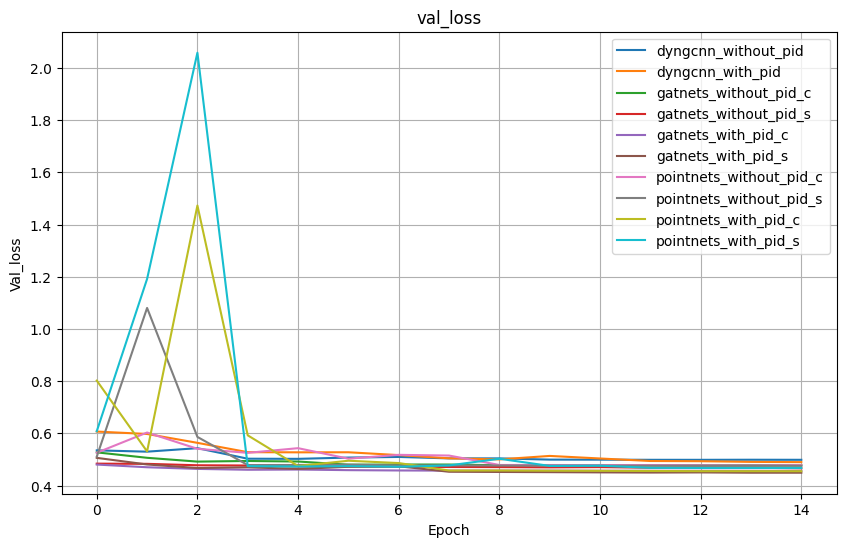

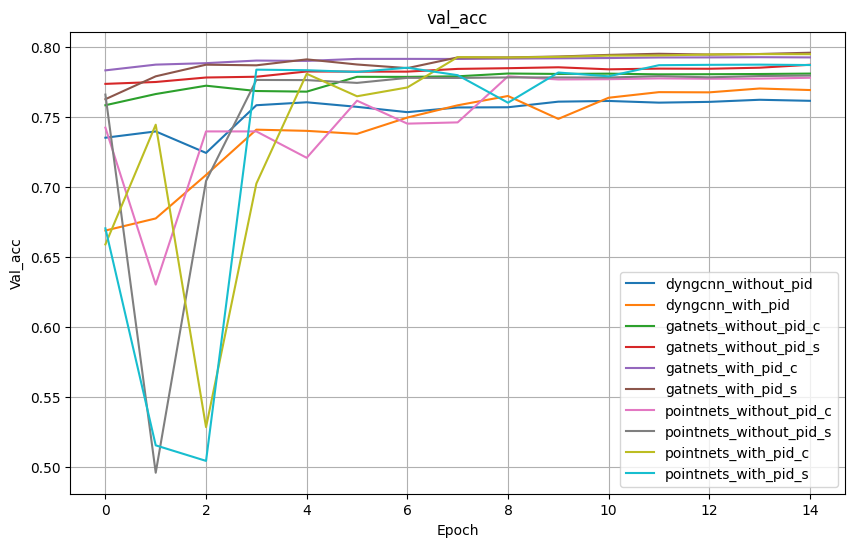

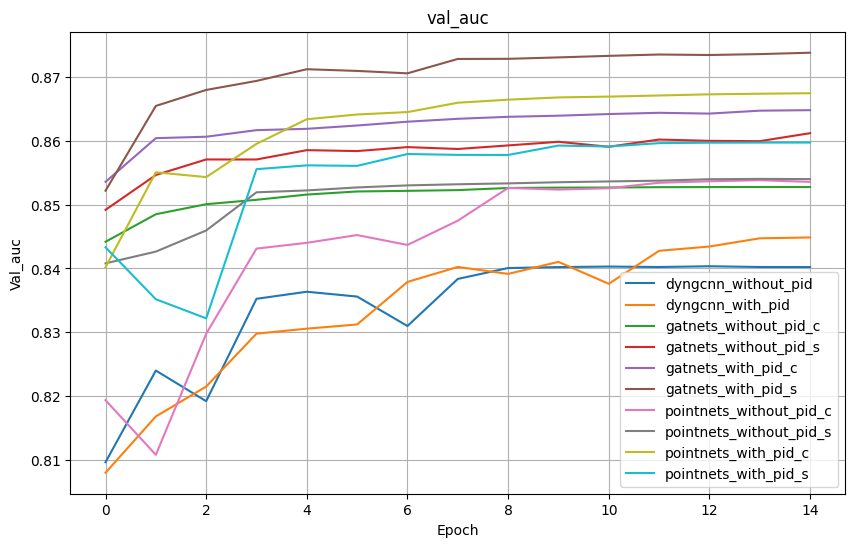

In [17]:
# Define the directory where your logs are stored
log_dir = 'logs'
models = ['dyngcnn_without_pid', 'dyngcnn_with_pid', 
          'gatnets_without_pid_c', 'gatnets_without_pid_s', 
          'gatnets_with_pid_c', 'gatnets_with_pid_s',
          'pointnets_without_pid_c', 'pointnets_without_pid_s', 
          'pointnets_with_pid_c', 'pointnets_with_pid_s']

# Initialize an empty DataFrame to hold all the data
model_metrics = {}

# Iterate over models and read their metrics
for model in models:
    file_path = os.path.join(log_dir, model, 'version_0/metrics.csv')
    if os.path.exists(file_path):
        model_metrics[model] = pd.read_csv(file_path).groupby('epoch').mean()
        
metrics_to_plot = ['val_loss', 'val_acc', 'val_auc']

for metric in metrics_to_plot:
    plt.figure(figsize=(10, 6))
    
    for model, df in model_metrics.items():
        # Check if the metric column exists in the dataframe
        if metric in df.columns:
            plt.plot(df.index, df[metric], label=model)
    plt.grid(True)
    plt.title(metric)
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.show()

From the analysis of the plots, it appears that the top-performing model is "gatnets_with_pid_s" (Graph Attention Network with Sparse Graphs Input), which also achieved the best "test_auc" of ~0.868 and "test_acc" of ~79.4%. Following closely behind is "pointnets_with_pid_c" (PointNet with Complete Graphs Input) with performance well within the margin of error. On the other hand, iterations of Dynamic Graph CNN model have the poorest performance, potentially due to suboptimal settings for the parameter k in its KNN stages. Additionally, exploring alternative aggregation schemes beyond max pooling in the graph layers of PointNet and Dynamic Graph CNN might result in better performance. 

It's worth noting that iterations excluding PID information generally display a performance drop of around 0.01 compared to their counterparts that include this information, agreeing with other experimenets from [1]. Overall, the best implemented graph model are still about 3% less performant than the corresponding model in [1], where the best achieves ~0.9 in AUC score. We expect that increasing the complexity of the network and number of training samples will close the gap. 

### References

* [1] P. T. Komiske, E. M. Metodiev, and J. Thaler, “Energy Flow Networks: Deep Sets for Particle Jets,” J. High Energ. Phys., vol. 2019, no. 1, p. 121, Jan. 2019, doi: 10.1007/JHEP01(2019)121.
* [2] C. R. Qi, L. Yi, H. Su, and L. J. Guibas, “PointNet++: Deep Hierarchical Feature Learning on Point Sets in a Metric Space.” arXiv, Jun. 07, 2017. Accessed: Apr. 05, 2024. [Online]. Available: http://arxiv.org/abs/1706.02413
* [3] Y. Wang, Y. Sun, Z. Liu, S. E. Sarma, M. M. Bronstein, and J. M. Solomon, “Dynamic Graph CNN for Learning on Point Clouds.” arXiv, Jun. 11, 2019. Accessed: Apr. 05, 2024. [Online]. Available: http://arxiv.org/abs/1801.07829
* [4] P. Veličković, G. Cucurull, A. Casanova, A. Romero, P. Liò, and Y. Bengio, “Graph Attention Networks.” arXiv, Feb. 04, 2018. Accessed: Apr. 05, 2024. [Online]. Available: http://arxiv.org/abs/1710.10903


